<a href="https://colab.research.google.com/github/bislara/CelebFaces-Attributes-GAN/blob/master/cGAN_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir .kaggle

In [0]:
import json

token = {"username":"biswajeetsahoo54","key":"1ce5cac341a71f094959287c3a210236"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json  /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
unanimad/dataisbeautiful                                    Reddit - Data is Beautiful                           11MB  2020-03-21 22:28:28            745  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)  646MB  2020-03-20 23:31:34          27877  
rubenssjr/brasilian-houses-to-rent                          brazilian_houses_to_rent                            117KB  2020-03-15 01:12:22            714  
sudalairajkumar/novel-corona-virus-2019-dataset             Novel Corona Virus 2019 Dataset                     412KB  2020-03-24 06:10:13          77438  
kimjihoo/coronavirusdataset                                 Data

In [0]:
!kaggle datasets download -d zalando-research/fashionmnist

 83% 57.0M/68.8M [00:00<00:00, 56.9MB/s]
100% 68.8M/68.8M [00:00<00:00, 78.7MB/s]


In [0]:
!unzip \*.zip

Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


In [0]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [0]:
class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('fashion-mnist_train.csv')
        self.labels = fashion_df.label.values
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [3]:
dataset = FashionMNIST()
# from PIL import Image 
# from google.colab.patches import cv2_imshow
# # img = Image.open(dataset[0][0])
# # img.show()
# img = dataset[0][0].save(fp="test",format="PNG")
print(dataset)
print(len(dataset))
print((dataset[1][0].size))
dataset[1][0]

60000
(28, 28)


In [0]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])
dataset = FashionMNIST(transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

In [5]:
print(dataloader)
print(len(dataloader))

15000


In [0]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [7]:
# Plot some training images
import torchvision.utils as vutils
classes=['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(classes)

['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


torch.Size([4, 1, 28, 28])


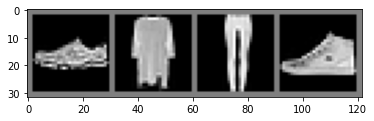

Sneaker Dress Trouser Sneaker


In [8]:
import torchvision

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get rand image
dataiter = iter(dataloader)
images, labels = dataiter.next()

print(images.size())
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),   #794 after adding 10 columns of labels in the array
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)  # 28*28=784 Image is of size 28*28
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [0]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [0]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [0]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data

In [0]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data

In [0]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

Streaming output truncated to the last 5000 lines.
[0/10][5004/15000]	Loss_D: 0.3148	Loss_G: 1.8003
[0/10][5006/15000]	Loss_D: 1.5685	Loss_G: 1.2741
[0/10][5008/15000]	Loss_D: 0.8588	Loss_G: 1.2370
[0/10][5010/15000]	Loss_D: 0.4136	Loss_G: 1.8945
[0/10][5012/15000]	Loss_D: 0.7727	Loss_G: 1.4742
[0/10][5014/15000]	Loss_D: 0.5358	Loss_G: 1.5473
[0/10][5016/15000]	Loss_D: 1.1888	Loss_G: 2.0111
[0/10][5018/15000]	Loss_D: 1.8025	Loss_G: 1.5955
[0/10][5020/15000]	Loss_D: 0.7893	Loss_G: 1.5701
[0/10][5022/15000]	Loss_D: 0.5246	Loss_G: 0.8821
[0/10][5024/15000]	Loss_D: 0.3549	Loss_G: 0.6313
[0/10][5026/15000]	Loss_D: 2.3883	Loss_G: 1.7835
[0/10][5028/15000]	Loss_D: 0.6469	Loss_G: 1.6535
[0/10][5030/15000]	Loss_D: 1.1706	Loss_G: 1.1078
[0/10][5032/15000]	Loss_D: 1.2650	Loss_G: 1.1630
[0/10][5034/15000]	Loss_D: 0.9329	Loss_G: 1.7080
[0/10][5036/15000]	Loss_D: 0.9909	Loss_G: 2.0797
[0/10][5038/15000]	Loss_D: 1.4205	Loss_G: 1.6329
[0/10][5040/15000]	Loss_D: 1.4479	Loss_G: 2.1982
[0/10][5042/15000]

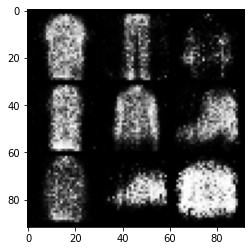

Streaming output truncated to the last 5000 lines.
[1/10][5004/15000]	Loss_D: 0.7462	Loss_G: 1.0821
[1/10][5006/15000]	Loss_D: 1.7330	Loss_G: 0.9970
[1/10][5008/15000]	Loss_D: 1.2808	Loss_G: 1.3690
[1/10][5010/15000]	Loss_D: 1.4986	Loss_G: 1.2285
[1/10][5012/15000]	Loss_D: 1.6665	Loss_G: 1.6970
[1/10][5014/15000]	Loss_D: 0.8273	Loss_G: 0.8858
[1/10][5016/15000]	Loss_D: 1.0262	Loss_G: 0.9784
[1/10][5018/15000]	Loss_D: 1.6195	Loss_G: 0.8605
[1/10][5020/15000]	Loss_D: 1.4149	Loss_G: 0.9101
[1/10][5022/15000]	Loss_D: 1.0318	Loss_G: 1.4647
[1/10][5024/15000]	Loss_D: 1.3941	Loss_G: 1.1300
[1/10][5026/15000]	Loss_D: 1.3219	Loss_G: 0.7411
[1/10][5028/15000]	Loss_D: 1.7555	Loss_G: 1.3097
[1/10][5030/15000]	Loss_D: 1.6629	Loss_G: 1.0192
[1/10][5032/15000]	Loss_D: 1.2663	Loss_G: 1.4936
[1/10][5034/15000]	Loss_D: 1.4196	Loss_G: 0.9115
[1/10][5036/15000]	Loss_D: 1.4479	Loss_G: 0.8747
[1/10][5038/15000]	Loss_D: 1.3785	Loss_G: 0.8817
[1/10][5040/15000]	Loss_D: 1.2313	Loss_G: 1.0231
[1/10][5042/15000]

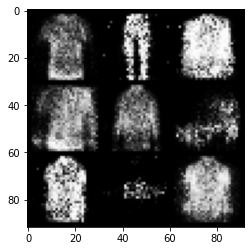

Streaming output truncated to the last 5000 lines.
[2/10][5004/15000]	Loss_D: 1.2421	Loss_G: 0.9765
[2/10][5006/15000]	Loss_D: 1.2875	Loss_G: 1.1481
[2/10][5008/15000]	Loss_D: 1.0147	Loss_G: 0.7509
[2/10][5010/15000]	Loss_D: 1.2276	Loss_G: 0.7049
[2/10][5012/15000]	Loss_D: 0.9698	Loss_G: 0.6792
[2/10][5014/15000]	Loss_D: 1.2086	Loss_G: 0.8650
[2/10][5016/15000]	Loss_D: 1.2082	Loss_G: 0.5226
[2/10][5018/15000]	Loss_D: 1.3865	Loss_G: 0.7141
[2/10][5020/15000]	Loss_D: 0.9184	Loss_G: 1.1043
[2/10][5022/15000]	Loss_D: 1.1895	Loss_G: 0.7822
[2/10][5024/15000]	Loss_D: 1.2267	Loss_G: 0.6613
[2/10][5026/15000]	Loss_D: 1.5409	Loss_G: 0.6656
[2/10][5028/15000]	Loss_D: 1.1846	Loss_G: 0.9240
[2/10][5030/15000]	Loss_D: 1.4982	Loss_G: 1.1869
[2/10][5032/15000]	Loss_D: 1.3862	Loss_G: 0.7945
[2/10][5034/15000]	Loss_D: 1.5878	Loss_G: 1.0173
[2/10][5036/15000]	Loss_D: 1.4022	Loss_G: 1.0873
[2/10][5038/15000]	Loss_D: 1.2000	Loss_G: 1.0457
[2/10][5040/15000]	Loss_D: 1.2547	Loss_G: 0.9248
[2/10][5042/15000]

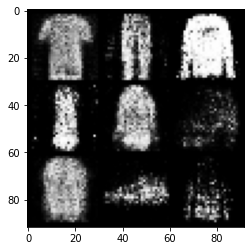

Streaming output truncated to the last 5000 lines.
[3/10][5004/15000]	Loss_D: 1.1767	Loss_G: 0.7578
[3/10][5006/15000]	Loss_D: 1.1933	Loss_G: 0.9490
[3/10][5008/15000]	Loss_D: 1.2232	Loss_G: 0.7130
[3/10][5010/15000]	Loss_D: 1.1798	Loss_G: 0.6058
[3/10][5012/15000]	Loss_D: 1.0648	Loss_G: 0.6466
[3/10][5014/15000]	Loss_D: 1.2596	Loss_G: 0.7418
[3/10][5016/15000]	Loss_D: 1.3242	Loss_G: 0.7377
[3/10][5018/15000]	Loss_D: 0.9860	Loss_G: 0.9765
[3/10][5020/15000]	Loss_D: 1.2122	Loss_G: 0.9305
[3/10][5022/15000]	Loss_D: 1.1411	Loss_G: 0.6955
[3/10][5024/15000]	Loss_D: 1.1544	Loss_G: 0.8042
[3/10][5026/15000]	Loss_D: 1.1966	Loss_G: 0.7598
[3/10][5028/15000]	Loss_D: 1.2583	Loss_G: 0.8607
[3/10][5030/15000]	Loss_D: 1.0938	Loss_G: 0.8595
[3/10][5032/15000]	Loss_D: 1.4991	Loss_G: 0.7283
[3/10][5034/15000]	Loss_D: 1.3496	Loss_G: 0.7559
[3/10][5036/15000]	Loss_D: 1.3013	Loss_G: 0.9915
[3/10][5038/15000]	Loss_D: 1.1651	Loss_G: 0.9790
[3/10][5040/15000]	Loss_D: 1.3482	Loss_G: 0.8613
[3/10][5042/15000]

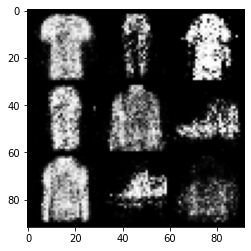

Streaming output truncated to the last 5000 lines.
[4/10][5004/15000]	Loss_D: 1.0945	Loss_G: 0.6073
[4/10][5006/15000]	Loss_D: 1.3164	Loss_G: 0.6552
[4/10][5008/15000]	Loss_D: 1.1823	Loss_G: 0.9996
[4/10][5010/15000]	Loss_D: 1.3528	Loss_G: 0.7667
[4/10][5012/15000]	Loss_D: 1.2160	Loss_G: 0.8620
[4/10][5014/15000]	Loss_D: 1.3633	Loss_G: 0.5196
[4/10][5016/15000]	Loss_D: 1.2492	Loss_G: 0.6576
[4/10][5018/15000]	Loss_D: 1.1058	Loss_G: 0.7307
[4/10][5020/15000]	Loss_D: 1.0792	Loss_G: 0.8714
[4/10][5022/15000]	Loss_D: 1.0707	Loss_G: 1.0480
[4/10][5024/15000]	Loss_D: 1.2575	Loss_G: 0.8393
[4/10][5026/15000]	Loss_D: 1.1400	Loss_G: 0.7470
[4/10][5028/15000]	Loss_D: 1.6069	Loss_G: 0.7495
[4/10][5030/15000]	Loss_D: 1.0636	Loss_G: 0.7460
[4/10][5032/15000]	Loss_D: 1.4912	Loss_G: 0.7408
[4/10][5034/15000]	Loss_D: 1.3881	Loss_G: 0.8318
[4/10][5036/15000]	Loss_D: 1.4422	Loss_G: 0.7991
[4/10][5038/15000]	Loss_D: 1.2411	Loss_G: 0.7459
[4/10][5040/15000]	Loss_D: 1.3137	Loss_G: 0.9339
[4/10][5042/15000]

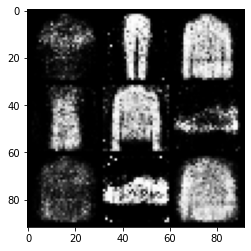

Streaming output truncated to the last 5000 lines.
[5/10][5004/15000]	Loss_D: 1.3208	Loss_G: 0.8859
[5/10][5006/15000]	Loss_D: 1.2777	Loss_G: 0.8849
[5/10][5008/15000]	Loss_D: 1.6728	Loss_G: 0.9052
[5/10][5010/15000]	Loss_D: 1.4341	Loss_G: 0.8698
[5/10][5012/15000]	Loss_D: 1.3354	Loss_G: 0.5723
[5/10][5014/15000]	Loss_D: 1.3258	Loss_G: 0.7403
[5/10][5016/15000]	Loss_D: 1.0343	Loss_G: 0.8219
[5/10][5018/15000]	Loss_D: 1.3667	Loss_G: 0.6505
[5/10][5020/15000]	Loss_D: 1.7179	Loss_G: 0.6847
[5/10][5022/15000]	Loss_D: 1.2176	Loss_G: 0.7543
[5/10][5024/15000]	Loss_D: 1.1543	Loss_G: 0.7684
[5/10][5026/15000]	Loss_D: 1.3124	Loss_G: 0.6885
[5/10][5028/15000]	Loss_D: 1.4908	Loss_G: 0.6247
[5/10][5030/15000]	Loss_D: 1.1236	Loss_G: 0.7302
[5/10][5032/15000]	Loss_D: 1.4864	Loss_G: 0.6786
[5/10][5034/15000]	Loss_D: 1.3430	Loss_G: 0.7569
[5/10][5036/15000]	Loss_D: 1.4906	Loss_G: 0.9359
[5/10][5038/15000]	Loss_D: 1.2260	Loss_G: 0.7732
[5/10][5040/15000]	Loss_D: 1.5871	Loss_G: 0.9135
[5/10][5042/15000]

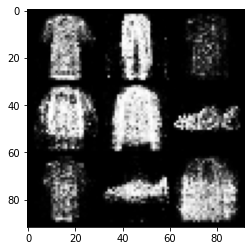

Streaming output truncated to the last 5000 lines.
[6/10][5004/15000]	Loss_D: 1.1187	Loss_G: 0.6545
[6/10][5006/15000]	Loss_D: 1.1062	Loss_G: 0.7793
[6/10][5008/15000]	Loss_D: 1.2893	Loss_G: 0.5505
[6/10][5010/15000]	Loss_D: 1.4205	Loss_G: 0.8842
[6/10][5012/15000]	Loss_D: 1.4669	Loss_G: 0.7298
[6/10][5014/15000]	Loss_D: 1.3532	Loss_G: 0.6387
[6/10][5016/15000]	Loss_D: 1.3509	Loss_G: 0.6660
[6/10][5018/15000]	Loss_D: 1.5322	Loss_G: 0.6179
[6/10][5020/15000]	Loss_D: 1.1005	Loss_G: 0.6921
[6/10][5022/15000]	Loss_D: 1.8767	Loss_G: 0.8742
[6/10][5024/15000]	Loss_D: 1.5796	Loss_G: 0.7470
[6/10][5026/15000]	Loss_D: 1.9152	Loss_G: 0.8087
[6/10][5028/15000]	Loss_D: 1.4074	Loss_G: 0.7750
[6/10][5030/15000]	Loss_D: 1.0830	Loss_G: 0.7451
[6/10][5032/15000]	Loss_D: 1.2981	Loss_G: 1.0172
[6/10][5034/15000]	Loss_D: 1.3960	Loss_G: 0.9207
[6/10][5036/15000]	Loss_D: 1.2434	Loss_G: 0.8206
[6/10][5038/15000]	Loss_D: 1.3289	Loss_G: 0.8019
[6/10][5040/15000]	Loss_D: 1.3071	Loss_G: 0.7511
[6/10][5042/15000]

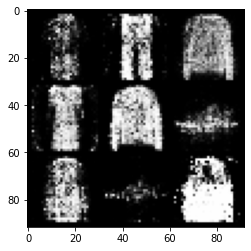

Streaming output truncated to the last 5000 lines.
[7/10][5004/15000]	Loss_D: 1.3802	Loss_G: 0.8647
[7/10][5006/15000]	Loss_D: 1.2163	Loss_G: 0.7646
[7/10][5008/15000]	Loss_D: 0.9268	Loss_G: 0.6839
[7/10][5010/15000]	Loss_D: 1.5560	Loss_G: 0.5432
[7/10][5012/15000]	Loss_D: 1.3613	Loss_G: 0.5401
[7/10][5014/15000]	Loss_D: 1.4001	Loss_G: 0.6693
[7/10][5016/15000]	Loss_D: 1.4226	Loss_G: 0.6638
[7/10][5018/15000]	Loss_D: 1.3946	Loss_G: 0.8305
[7/10][5020/15000]	Loss_D: 1.4537	Loss_G: 0.7677
[7/10][5022/15000]	Loss_D: 1.3152	Loss_G: 0.5890
[7/10][5024/15000]	Loss_D: 1.4306	Loss_G: 0.9268
[7/10][5026/15000]	Loss_D: 1.5314	Loss_G: 0.9204
[7/10][5028/15000]	Loss_D: 1.3740	Loss_G: 0.5987
[7/10][5030/15000]	Loss_D: 1.3881	Loss_G: 0.7361
[7/10][5032/15000]	Loss_D: 1.1984	Loss_G: 0.8049
[7/10][5034/15000]	Loss_D: 1.3509	Loss_G: 0.7519
[7/10][5036/15000]	Loss_D: 0.8434	Loss_G: 0.7375
[7/10][5038/15000]	Loss_D: 1.1644	Loss_G: 0.8137
[7/10][5040/15000]	Loss_D: 1.1544	Loss_G: 0.6207
[7/10][5042/15000]

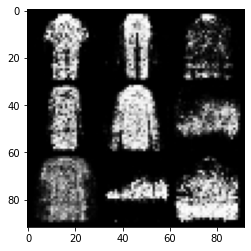

Streaming output truncated to the last 5000 lines.
[8/10][5004/15000]	Loss_D: 1.5216	Loss_G: 0.9555
[8/10][5006/15000]	Loss_D: 1.1319	Loss_G: 0.7018
[8/10][5008/15000]	Loss_D: 1.1531	Loss_G: 0.8425
[8/10][5010/15000]	Loss_D: 1.3132	Loss_G: 0.9216
[8/10][5012/15000]	Loss_D: 1.2890	Loss_G: 0.8856
[8/10][5014/15000]	Loss_D: 1.2968	Loss_G: 0.6547
[8/10][5016/15000]	Loss_D: 1.3743	Loss_G: 0.7538
[8/10][5018/15000]	Loss_D: 1.2049	Loss_G: 0.7276
[8/10][5020/15000]	Loss_D: 1.2990	Loss_G: 0.6995
[8/10][5022/15000]	Loss_D: 1.0915	Loss_G: 0.6313
[8/10][5024/15000]	Loss_D: 1.0654	Loss_G: 0.6998
[8/10][5026/15000]	Loss_D: 1.3419	Loss_G: 0.7530
[8/10][5028/15000]	Loss_D: 1.0749	Loss_G: 0.6104
[8/10][5030/15000]	Loss_D: 1.0892	Loss_G: 0.6304
[8/10][5032/15000]	Loss_D: 1.4623	Loss_G: 0.7710
[8/10][5034/15000]	Loss_D: 1.3719	Loss_G: 0.6331
[8/10][5036/15000]	Loss_D: 1.4858	Loss_G: 0.6932
[8/10][5038/15000]	Loss_D: 1.1138	Loss_G: 0.6630
[8/10][5040/15000]	Loss_D: 1.2932	Loss_G: 0.7930
[8/10][5042/15000]

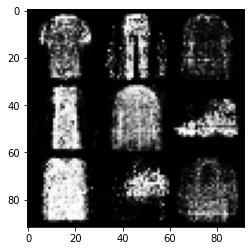

Streaming output truncated to the last 5000 lines.
[9/10][5004/15000]	Loss_D: 1.5727	Loss_G: 0.7408
[9/10][5006/15000]	Loss_D: 1.2408	Loss_G: 0.7739
[9/10][5008/15000]	Loss_D: 1.4290	Loss_G: 0.6373
[9/10][5010/15000]	Loss_D: 1.2548	Loss_G: 0.7265
[9/10][5012/15000]	Loss_D: 1.3944	Loss_G: 0.6651
[9/10][5014/15000]	Loss_D: 1.3047	Loss_G: 0.7610
[9/10][5016/15000]	Loss_D: 1.4835	Loss_G: 0.8635
[9/10][5018/15000]	Loss_D: 1.2316	Loss_G: 0.8018
[9/10][5020/15000]	Loss_D: 1.5065	Loss_G: 0.7008
[9/10][5022/15000]	Loss_D: 1.2270	Loss_G: 0.8221
[9/10][5024/15000]	Loss_D: 1.3140	Loss_G: 0.7028
[9/10][5026/15000]	Loss_D: 1.3780	Loss_G: 0.7365
[9/10][5028/15000]	Loss_D: 1.0687	Loss_G: 0.8258
[9/10][5030/15000]	Loss_D: 1.4016	Loss_G: 0.7553
[9/10][5032/15000]	Loss_D: 1.3591	Loss_G: 0.7325
[9/10][5034/15000]	Loss_D: 1.3908	Loss_G: 0.6838
[9/10][5036/15000]	Loss_D: 1.2495	Loss_G: 0.7846
[9/10][5038/15000]	Loss_D: 1.3524	Loss_G: 0.7178
[9/10][5040/15000]	Loss_D: 1.3402	Loss_G: 0.7621
[9/10][5042/15000]

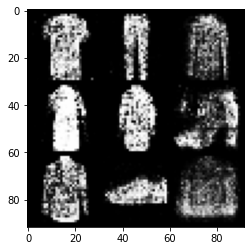

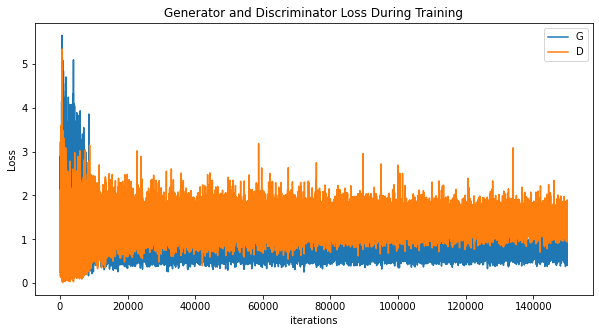

In [19]:
num_epochs = 10
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(dataloader):
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,generator, d_optimizer, criterion,real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        if i % 2 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch, num_epochs, i, len(dataloader),d_loss,g_loss))
        
        # Save Losses for plotting later
        G_losses.append(g_loss)
        D_losses.append(d_loss)
        


    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).to(device)
    labels = Variable(torch.LongTensor(np.arange(9))).to(device)
    sample_images = generator(z, labels).unsqueeze(1).data.to(device)
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()


plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [0]:
z = Variable(torch.randn(100, 100)).to(device)
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).to(device)
sample_images = generator(z, labels).unsqueeze(1).data.to(device)
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
# _ = plt.xticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, fontsize=20)
_ = plt.xticks(np.arange(15, 300, 30), classes, rotation=45, fontsize=20)